In [1]:
import pandas as pd
import xarray as xr
#from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
#import cartopy
#from cartopy.util import add_cyclic_point
#import cartopy.crs as ccrs
#from cartopy.mpl.geoaxes import GeoAxes
#from mpl_toolkits.axes_grid1 import AxesGrid
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
    
        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='year')
         
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='year')
        x,y = xr.align(x,y)
        
    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='year')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [3]:
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR',
       'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5',
       'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'E3SM-1-1', 'EC-Earth3',
       'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L',
       'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']

In [4]:
change_frac_wap_models = []
change_ts_models = []
for model in models:
    in_hist_wap = '/more_m/haibo/work/wap_Amon_'+model+'_historical_mean_185001-201412_500mb.nc'
    print(in_hist_wap)
    wap_hist = xr.open_dataset(in_hist_wap,decode_times=False)
    monthtime = pd.date_range(start='1850-01-01',periods=1980,freq='MS').shift(14,'D')
    wap_hist = wap_hist.assign_coords(time=(monthtime))
    in_hist_ts = '/dm4/haibo/CMIP6/ssp585hist/historical/Amon/ts/'+model+'/mean/ts_*.nc'

    ts_hist = xr.open_mfdataset(in_hist_ts,decode_times=False)
    if (model == 'FGOALS-g3'):
        ts_hist = ts_hist.isel(time=slice(0, -24))

    ts_hist = ts_hist.assign_coords(time=(monthtime))
    
    in_585_wap = '/more_m/haibo/work/wap_Amon_'+model+'_ssp585_mean_201501-210012_500mb.nc'
    print(in_585_wap)
    wap_585 = xr.open_dataset(in_585_wap,decode_times=False)
    monthtime = pd.date_range(start='2015-01-01',periods=1032,freq='MS').shift(14,'D')
    wap_585 = wap_585.assign_coords(time=(monthtime))  
    wap = xr.concat([wap_hist,wap_585],dim='time')
    wap = wap.sel(time=slice('1958-01-15','2020-12-15'),lon=slice(100,300),lat=slice(-30,30))
    wap_year = wap.groupby('time.year').mean('time')
    wap_year_mean = wap_year.mean('year')
    wap_year_plus = wap_year_mean.wap.where(wap_year_mean.wap<0) #upward moving
    #ds_wap_year_plus = wap_year_plus.to_dataset(name = 'wap')
    mask = wap_year_plus * 0 +1
    wap_year_masked = wap_year * mask
    wap_year_masked_area_ave = wap_year_masked.mean('lon').mean('lat')
    test = lag_linregress_3D(wap_year_masked_area_ave.year, wap_year_masked_area_ave.wap, lagx=0, lagy=0)
    change_frac_wap = test[2]*(wap_year_masked_area_ave.year[-1] - wap_year_masked_area_ave.year[0]) / \
            wap_year_masked_area_ave.mean('year')
    change_frac_wap_models.append(change_frac_wap.wap.values)
    
    in_585_ts = '/dm4/haibo/CMIP6/ssp585hist/ssp585/Amon/ts/'+model+'/mean/ts_*.nc'
    ts_585 = xr.open_mfdataset(in_585_ts,decode_times=False)
    ts_585 = ts_585.assign_coords(time=(monthtime))
    if 'lon_bnds' in ts_hist:
        ts_hist=ts_hist.drop('lon_bnds')
    if 'lat_bnds' in ts_hist:
        ts_hist=ts_hist.drop('lat_bnds')
    if 'time_bnds' in ts_hist:
        ts_hist=ts_hist.drop('time_bnds')

    if 'lon_bnds' in ts_585:
        ts_585=ts_585.drop('lon_bnds')
    if 'lat_bnds' in ts_585:
        ts_585=ts_585.drop('lat_bnds')
    if 'time_bnds' in ts_585:
        ts_585=ts_585.drop('time_bnds')
    
    ts = xr.concat([ts_hist,ts_585],dim='time')
    ts = ts.sel(time=slice('1958-01-15','2020-12-15')) 
    ts_year = ts.groupby('time.year').mean('time')
    #ds_ts_year = ts_year.to_dataset(name = 'ts')
    ts_year_area_ave = ts_year.mean('lon').mean('lat')
    test2 = lag_linregress_3D(ts_year_area_ave.year, ts_year_area_ave.ts, lagx=0, lagy=0)
    change_ts = test2[2]*(ts_year_area_ave.year[-1] - ts_year_area_ave.year[0])
    change_ts_models.append(change_ts.values)

/more_m/haibo/work/wap_Amon_ACCESS-CM2_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_ACCESS-CM2_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_ACCESS-ESM1-5_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_ACCESS-ESM1-5_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_AWI-CM-1-1-MR_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_AWI-CM-1-1-MR_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CAS-ESM2-0_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CAS-ESM2-0_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CESM2_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CESM2_ssp585_mean_201501-210012_500mb.nc


/usr/local/python/anaconda3/envs/pangeo-fall2020/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


/more_m/haibo/work/wap_Amon_CESM2-WACCM_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CESM2-WACCM_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CIESM_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CIESM_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CMCC-CM2-SR5_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CMCC-CM2-SR5_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CMCC-ESM2_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CMCC-ESM2_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CNRM-CM6-1_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CNRM-CM6-1_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CNRM-CM6-1-HR_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_CNRM-CM6-1-HR_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_CNRM-ESM2-1_historical_mean_185001-201412_500mb.nc
/more_m/h

/usr/local/python/anaconda3/envs/pangeo-fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/more_m/haibo/work/wap_Amon_EC-Earth3-CC_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_EC-Earth3-CC_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_EC-Earth3-Veg_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_EC-Earth3-Veg_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_EC-Earth3-Veg-LR_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_EC-Earth3-Veg-LR_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_FGOALS-f3-L_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_FGOALS-f3-L_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_FGOALS-g3_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_FGOALS-g3_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_FIO-ESM-2-0_historical_mean_185001-201412_500mb.nc
/more_m/haibo/work/wap_Amon_FIO-ESM-2-0_ssp585_mean_201501-210012_500mb.nc
/more_m/haibo/work/wap_Amon_GFDL-CM4_historical_mean_185001-2014

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


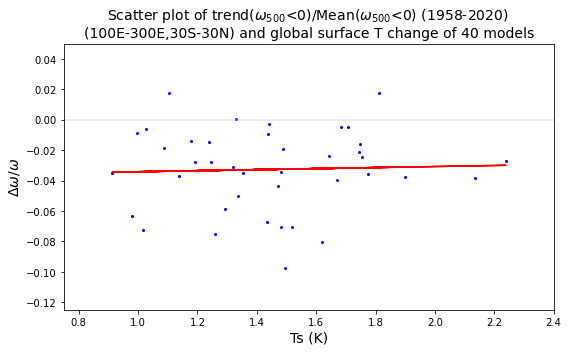

In [6]:
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.scatter(change_ts_models,change_frac_wap_models,color = 'b',s=4)
m, b = np.polyfit(change_ts_models,change_frac_wap_models, 1)
plt.plot(change_ts_models, m * np.array (change_ts_models) + b , color = 'r')
ax.set_ylim(-0.125,0.05)
ax.set_xlim(0.75,2.4)

ax.axhline(0,linestyle='-',color=(0.8,0.8,0.8,0.5))
ax.set_xlabel('Ts (K)',fontsize=14)
ax.set_ylabel('$\Delta \omega/\omega$',fontsize=14)
titletext = 'Scatter plot of trend($\omega_{500}$<0)/Mean($\omega_{500}$<0) (1958-2020) \n(100E-300E,30S-30N) and global surface T change of 40 models'
ax.set_title(titletext,fontsize=14)

ax.yaxis.set_minor_locator(MultipleLocator(1))
plt.tight_layout()
plt.savefig('/home/haibo/plot/scatter_wap_frac_trend_ts_change_1958-2020.ps')